## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
import urllib.request

url = "https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt"
filename = "onegin.txt"

if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename, 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

print("Loaded lines:", len(text))


Loaded lines: 7088


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [8]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [17]:
# dict <index>:<char>
idx_to_token = {i: ch for i, ch in enumerate(tokens)}

# dict <char>:<index>
token_to_id = {ch: i for i, ch in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = len(tokens)

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity="tanh",
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def initial_state(self, batch_size=1):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

    def forward(self, x, h0=None):

        if x.dim() == 2 and x.size(1) == 1:
            x = x.squeeze(1)  # [B]
        if x.dim() != 1:
            raise ValueError(f"Expected x indices [B] or [B,1], got {tuple(x.shape)}")

        B = x.size(0)
        if h0 is None:
            h0 = self.initial_state(batch_size=B)

        x_oh = F.one_hot(x, num_classes=self.vocab_size).float()
        x_oh = x_oh.unsqueeze(1)

        out, h = self.rnn(x_oh, h0)
        logits = self.fc(out[:, 0, :])
        return logits, h

model = CharRNN(vocab_size=vocab_size, hidden_size=256, num_layers=1).to(device)
print(model)


CharRNN(
  (rnn): RNN(83, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=83, bias=True)
)


In [ ]:
import numpy as np

SEQ_LEN = 80
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 1e-3

text_ids = np.array([token_to_id[ch] for ch in text], dtype=np.int64)

def sample_batch(ids, seq_len, batch_size, device):
    max_start = len(ids) - seq_len - 1
    starts = np.random.randint(0, max_start, size=batch_size)
    x = np.stack([ids[s:s+seq_len] for s in starts], axis=0)       # [B,T]
    y = np.stack([ids[s+1:s+seq_len+1] for s in starts], axis=0)   # [B,T]
    x = torch.tensor(x, dtype=torch.int64, device=device)
    y = torch.tensor(y, dtype=torch.int64, device=device)
    return x, y

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_history = []

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    n_steps = 200

    for _ in range(n_steps):
        x, y = sample_batch(text_ids, SEQ_LEN, BATCH_SIZE, device)
        h = model.initial_state(batch_size=BATCH_SIZE)

        loss = 0.0
        for t in range(SEQ_LEN):
            logits, h = model(x[:, t], h)
            loss = loss + criterion(logits, y[:, t])

        loss = loss / SEQ_LEN

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += float(loss.item())

    avg_loss = epoch_loss / n_steps
    loss_history.append(avg_loss)
    print(f"Epoch {epoch:02d} | loss: {avg_loss:.4f}")


Epoch 01 | loss: 3.1310
Epoch 02 | loss: 2.5651
Epoch 03 | loss: 2.3980
Epoch 04 | loss: 2.3054
Epoch 05 | loss: 2.2304
Epoch 06 | loss: 2.1656
Epoch 07 | loss: 2.1087
Epoch 08 | loss: 2.0553
Epoch 09 | loss: 2.0082
Epoch 10 | loss: 1.9657


Plot the loss function (axis X: number of epochs, axis Y: loss function).

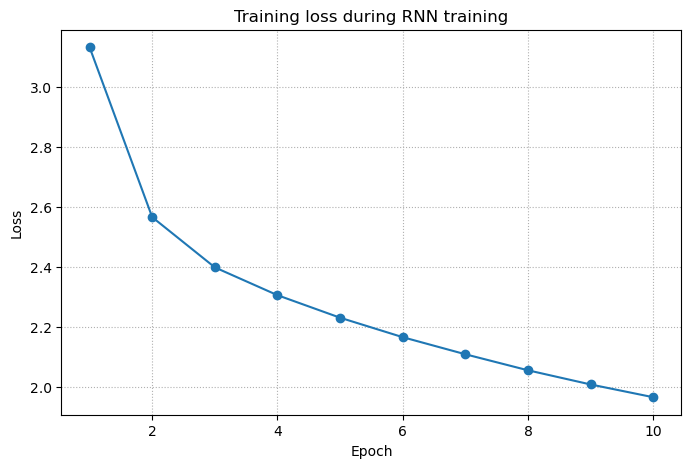

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss during RNN training")
plt.grid(True, linestyle=":")
plt.show()


In [ ]:
MAX_LENGTH = 500

def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    char_rnn.eval()

    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64, device=device).unsqueeze(0)

    hid_state = char_rnn.initial_state(batch_size=1)

    with torch.no_grad():
        for i in range(x_sequence.size(1) - 1):
            _logits, hid_state = char_rnn(x_sequence[:, i], hid_state)

        for _ in range(max_length - x_sequence.size(1)):
            logits, hid_state = char_rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logits / temperature, dim=-1).detach().cpu().numpy()[0]

            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.squeeze(0).detach().cpu().numpy()])


In [ ]:
MAX_LENGTH = 500

def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    """
    Generates text given a seed phrase.
    Model expects token indices and returns logits for next token.
    """
    char_rnn.eval()

    x_sequence = [token_to_id[ch] for ch in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64, device=device).unsqueeze(0)

    hid_state = char_rnn.initial_state(batch_size=1)

    with torch.no_grad():
        for i in range(x_sequence.size(1) - 1):
            _logits, hid_state = char_rnn(x_sequence[:, i], hid_state)

        for _ in range(max_length - x_sequence.size(1)):
            logits, hid_state = char_rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logits / temperature, dim=-1).detach().cpu().numpy()[0]

            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.squeeze(0).detach().cpu().numpy()])


In [22]:
# An example of generated text.
print(generate_sample(model, seed_phrase="shall i ", max_length=500, temperature=0.8))

shall i llilie ttta5ta по селчаниех,
маетень к орегом своех,
чтоб ю что любить от прадет
тробою в пель замочен;
сердце утре иль дебы
хоном угрда не слегом.


vii

истоть межда и смаренный дам,
и стол, вол не богу; клогалой
и в это в нешной предовностом
заряные здала авне,
кремину двезям седрет,
и встушлит теть веречать нетя
ленской здул не всё так стросте
он мучей в много сдавор
не в дому пестолеть повожденой
как постраестих стерен всем…
вответ же такилости, клядьствы
в лечет верле на дува терем


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

Epoch 01 | LSTM loss: 3.2417
Epoch 02 | LSTM loss: 2.6693
Epoch 03 | LSTM loss: 2.5061
Epoch 04 | LSTM loss: 2.4305
Epoch 05 | LSTM loss: 2.3684
Epoch 06 | LSTM loss: 2.3224
Epoch 07 | LSTM loss: 2.2790
Epoch 08 | LSTM loss: 2.2403
Epoch 09 | LSTM loss: 2.1997
Epoch 10 | LSTM loss: 2.1651


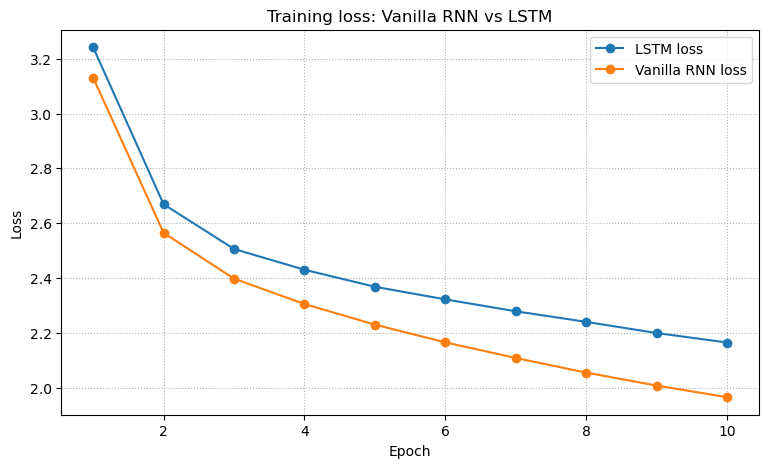

Final Vanilla RNN loss: 1.9657
Final LSTM loss       : 2.1651


In [ ]:
SEQ_LEN = 80
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 1e-3
N_STEPS = 200

vocab_size = len(tokens)

text_ids = np.array([token_to_id[ch] for ch in text], dtype=np.int64)

def sample_batch(ids, seq_len, batch_size, device):
    max_start = len(ids) - seq_len - 1
    starts = np.random.randint(0, max_start, size=batch_size)
    x = np.stack([ids[s:s+seq_len] for s in starts], axis=0)
    y = np.stack([ids[s+1:s+seq_len+1] for s in starts], axis=0)
    x = torch.tensor(x, dtype=torch.int64, device=device)
    y = torch.tensor(y, dtype=torch.int64, device=device)
    x_oh = F.one_hot(x, num_classes=vocab_size).float()
    return x_oh, y

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=1):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            state = (h0, c0)
        out, state = self.lstm(x, state)
        logits = self.fc(out)
        return logits, state

lstm_model = CharLSTM(vocab_size=vocab_size, hidden_size=256, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)

lstm_loss_history = []

for epoch in range(1, N_EPOCHS + 1):
    lstm_model.train()
    epoch_loss = 0.0

    for _ in range(N_STEPS):
        x_oh, y = sample_batch(text_ids, SEQ_LEN, BATCH_SIZE, device)
        logits, _ = lstm_model(x_oh, None)

        loss = criterion(logits.reshape(-1, vocab_size), y.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += float(loss.item())

    avg_loss = epoch_loss / N_STEPS
    lstm_loss_history.append(avg_loss)
    print(f"Epoch {epoch:02d} | LSTM loss: {avg_loss:.4f}")

plt.figure(figsize=(9, 5))

plt.plot(range(1, len(lstm_loss_history) + 1), lstm_loss_history, marker="o", label="LSTM loss")

if "loss_history" in globals() and len(loss_history) > 0:
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker="o", label="Vanilla RNN loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss: Vanilla RNN vs LSTM")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()

if "loss_history" in globals() and len(loss_history) > 0:
    print(f"Final Vanilla RNN loss: {loss_history[-1]:.4f}")
print(f"Final LSTM loss       : {lstm_loss_history[-1]:.4f}")


The LSTM model did not improve the final loss compared to the vanilla RNN under the same training settings (10 epochs, Adam optimizer, learning rate 1e-3).
Although the LSTM loss decreases during training, it remains higher at the end (2.165 vs 1.966).
Possible reasons include an insufficient number of training epochs for the LSTM, a suboptimal learning rate for this architecture, and the more complex optimization dynamics of LSTM compared to a simple RNN.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
TEMPERATURES = [0.1, 0.2, 0.5, 1.0, 2.0]
MAX_LENGTH = 500

def generate_text_indices(model, seed_phrase="the ", length=500, temperature=1.0, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    ids = [token_to_idx[ch] for ch in seed_phrase if ch in token_to_idx]
    if len(ids) == 0:
        ids = [0]

    hidden = None

    with torch.no_grad():
        for i in range(len(ids) - 1):
            x = torch.tensor([ids[i]], dtype=torch.int64, device=device)  # [B]
            logits, hidden = model(x, hidden)  # logits: [B, V] or [B,1,V] depending on your forward

        for _ in range(length - len(ids)):
            x = torch.tensor([ids[-1]], dtype=torch.int64, device=device)  # [B]
            logits, hidden = model(x, hidden)

            if logits.dim() == 3:
                last_logits = logits[0, -1]
            else:
                last_logits = logits[0]

            probs = F.softmax(last_logits / temperature, dim=-1).cpu().numpy()
            next_id = int(np.random.choice(len(tokens), p=probs))
            ids.append(next_id)

    return "".join(tokens[i] for i in ids)

for t in TEMPERATURES:
    print("=" * 80)
    print(f"Temperature = {t}")
    print(generate_text_indices(model, seed_phrase="the ", length=MAX_LENGTH, temperature=t))
    print()


Temperature = 0.1
the не в сердце доловой,
как в сердце пристать не постель
в дем верной простов не востей
с домала в онегин с построй
в сем не предала довговила
и в сладенил с постоветь может,
и всё в постеле на свот она
старин с поль он поленой своей,
в деме не подного своей
и столой страстей подруга
пристал сердце гостовой
и сладали своей доловать
и вере страстей в семенье друг,
и всё в сладе своей доловать
и всё в дель он полет собранье
страстей страстей в сем сердце доловой,
и всё в доленный последной,
и всё

Temperature = 0.2
the (н го доленных долоной,
и всё на страстей в семеньем
с дем онегин сторинный поле
не сталине своей душа
не може страсти с постоветь,
что в слад отродать не всё токой
сторой свет и в сердце доловой,
и все дем ведной простовенье,
в сем и дере страстей всердала
и в сладались в пострает построй
в сем не предала душа том,
не все давно уж не страстей
в сем не полете с переменный,
но в сель постолет и бластей
с дем верный раздоворь может,
не все дам востом после

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
import json
import torch

WEIGHTS_PATH = "char_rnn_weights.pt"
VOCAB_PATH   = "char_rnn_vocab.json"

torch.save(model.state_dict(), WEIGHTS_PATH)
with open(VOCAB_PATH, "w", encoding="utf-8") as f:
    json.dump({
        "tokens": tokens,
        "vocab_size": vocab_size,
        "hidden_size": getattr(model, "hidden_size", 256),
        "num_layers": getattr(model, "num_layers", 1),
    }, f, ensure_ascii=False)

print(f"Saved weights to: {WEIGHTS_PATH}")
print(f"Saved vocab   to: {VOCAB_PATH}")

with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    meta = json.load(f)

tokens = meta["tokens"]
token_to_idx = {ch: i for i, ch in enumerate(tokens)}
idx_to_token = {i: ch for i, ch in enumerate(tokens)}
vocab_size = meta["vocab_size"]

loaded_model = CharRNN(
    vocab_size=vocab_size,
    hidden_size=meta["hidden_size"],
    num_layers=meta["num_layers"],
).to(device)

state = torch.load(WEIGHTS_PATH, map_location=device, weights_only=True)
loaded_model.load_state_dict(state)
loaded_model.eval()

print("Loaded model OK.\n")
print(generate_text_indices(loaded_model, seed_phrase="the ", length=500, temperature=0.5))


Saved weights to: char_rnn_weights.pt
Saved vocab   to: char_rnn_vocab.json
Loaded model OK.

the не в нечала сторок
оставит соднет он отворить
и бладцу тро было островаль,
и все доворный как и быть
и слугань моня предружденье,
разголов наказаны след
не стравал страмные стристей,
пред всё и подного страстей
не кам пород на дель он одно,
покронной склонный проститель?
но как в сера ссегда с ник.



xlviii

в тем передем в его с венный стерет,
онегин в поском просторода
сердце всё в день моя другой,
как и подом в склод облидера
пославь в придетти свае странный,
мой онегин толждо с олагом,



### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)